# An example with stochastic gradient

We test the robust of using a stable proposal on an example in which noises are injected into the gradient.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *
import MC_diag as d

The example is taken directly from Chen et al. (2014).  The potential of interest is

\begin{equation}
U(x) = x^4 - 2x^2,
\end{equation}

meaning the true gradient is $\nabla U(x) = 4x^3 - 4x$.  The stochastic gradient implemented within the sampler is

\begin{equation}
\nabla \tilde{U} (x) = 4x^3 - 4x + \xi,
\end{equation}

where $\xi \sim N(0,2^2)$.  A stepsize of $\varepsilon = 0.1$ is chosen for all examples, and we shall choose the same in our test.

In [2]:
# Create potential class
class SG_Example:
    """Stochastic gradient example"""        
    def value(self, x):
        return x**4 - 2*x**2
    
    def grad(self, x):
        xi = 2*np.random.randn(1) # inject random noise into gradient
        return 4*x**3 - 4*x + xi
    
U = SG_Example()
print U.value(2)
print U.grad(2)
print U.grad(2)

8
[ 25.74757929]
[ 22.80085385]


First we run some simple 'robust in the tail' simulations.

In [ ]:
# Try gradients from out in the tails and plot the histogram
K = PE_family(5.0/4)
p = K.sample(1)

K.grad(-e/2.0 * U.grad(x) + p)
# INSERT finish off if needed...

Acceptance rate: 0.000000
LF Steps: 50, Step-size: 0.100
Numerical divergences: 0
Acceptance rate: 0.000000
LF Steps: 50, Step-size: 0.100
Numerical divergences: 0


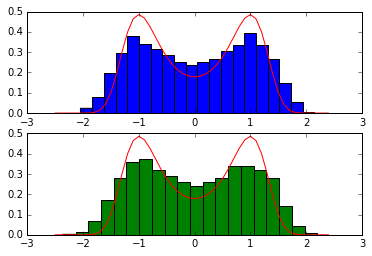

In [27]:
# Run HMC without Metropolis--Hastings, using L = 50 and e = 0.1.  Plot histogram to see what it looks like.
nits = 10000
L = 50
e = 0.1
U = SG_Example()
K = PE_family(4.0/3)
x_input = np.array([0.0])

# naive SGHMC with PE43 momentum
samples = h.HMC(nits, x_input, U, K, L, e, BurnIn = 0, Random = False, MH = False)
x_samples = samples['x']

# naive SGHMC with gaussian momenta
K2 = Gauss()
samples2 = h.HMC(nits, x_input, U, K2, L, e, BurnIn = 0, Random = False, MH = False)
x_samples2 = samples2['x']

# create the truth
def density(x):
    n = len(np.atleast_1d(x))
    d = []
    for i in xrange(n):
        temp = exp(-x[i]**4 + 2*x[i]**2) / 5.6
        d.append(temp)
    return d

x_grid = np.arange(-2.5,2.5,0.1)
d_grid = density(x_grid)

# plot results
plt.subplot(211)
plt.hist(x_samples[0,:], normed = True, bins = 20);
plt.plot(x_grid, d_grid, 'r-');

plt.subplot(212)
plt.hist(x_samples2[0,:], normed = True, bins = 20, color='green');
plt.plot(x_grid, d_grid, 'r-');

The blue curve is slightly more accurate than the green, however there is still a clear bias.  Either a relativistic kernel or combining with the underdamping of second order Langevin might be necessary here. The bias is likely caused by what is happening when the potential is large.

Next consider with a larger stepsize. We dampen the kinetic energy slightly more here to be more robust.

Acceptance rate: 0.000000
LF Steps: 50, Step-size: 0.500
Numerical divergences: 0


/Users/samlivingstone/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in power
/Users/samlivingstone/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in subtract


Acceptance rate: 0.000000
LF Steps: 50, Step-size: 0.500
Numerical divergences: 0


ValueError: max must be larger than min in range parameter.

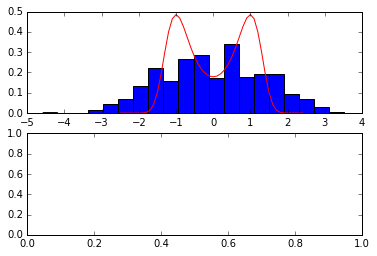

In [30]:
# Run HMC without Metropolis--Hastings, using L = 50 and e = 0.1.  Plot histogram to see what it looks like.
nits = 10000
L = 50
e = 0.5
U = SG_Example()
K = PE_family(5.0/4)
x_input = np.array([0.0])

# naive SGHMC with PE43 momentum
samples = h.HMC(nits, x_input, U, K, L, e, BurnIn = 0, Random = False, MH = False)
x_samples = samples['x']

# naive SGHMC with gaussian momenta
K2 = Gauss()
samples2 = h.HMC(nits, x_input, U, K2, L, e, BurnIn = 0, Random = False, MH = False)
x_samples2 = samples2['x']

# plot results
plt.subplot(211)
plt.hist(x_samples[0,:], normed = True, bins = 20);
plt.plot(x_grid, d_grid, 'r-');

plt.subplot(212)
plt.hist(x_samples2[0,:], normed = True, bins = 20, color='green');
plt.plot(x_grid, d_grid, 'r-');

The heavier-tailed kinetic energy still produces a stable, albeit biased, flow.  The Gaussian choice, by comparison, produces a transient Markov chain due to unstable numerics.